<a href="https://colab.research.google.com/github/pederowasto/sentiment-analysis-tokopedia-review-dashboard/blob/main/pederowasto_proyekakhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

Pada kesempatan kali ini saya akan melakukan analisa sentiment pada sebuah platform e-commerce yaitu Tokopedia, seperti yang diketahui bahwa Tokopedia merupakan salah satu platform online jual beli terbesar yang ada di Indonesia, data akan di ambil dari review pengguna terhadap aplikasi Tokopedia dan data diambil dengan menggunakan scraping twitter dan google play store. Sehingga dapat diketahui opini masyarakat terhadap aplikasi ini dengan tujuan peningkatan kualitas aplikasi

# Library

In [ ]:
#!pip install --upgrade tweepy==4.5.0
#!pip install --upgrade tweepy
#!pip install Sastrawi
#print(tweepy.__version__)
#!pip install google-play-scraper

In [ ]:
#import library & package. 
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import json, requests, re
import tweepy
import string
import nltk
import Sastrawi
import seaborn as sns
import gensim
from gensim import corpora
from google_play_scraper import app
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from tweepy import Paginator
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from urllib.request import urlopen
from bs4 import BeautifulSoup
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Understanding

Tokopedia Data Collection from twitter with tweepy

In [ ]:
with open("tokens.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

In [ ]:
api = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

Pada kesempatan ini saya ingin scraping tweet tentang Sambo


In [ ]:
query = "tokopedia -is:verified -is:retweet -has:links lang:id"
start_time = "2023-01-15T18:05:00Z"
end_time = "2023-01-18T23:59:59.698Z"
response = tweepy.Paginator(api.search_recent_tweets,
                          tweet_fields=['context_annotations','created_at'],
                          query = query,
                          max_results=100
                          ).flatten(limit=500)

Dari hasil screeping kita gunakan fungsi "context_annotations" untuk mengambil data pada tweet tersebut seperti domain, name, description, entity

In [ ]:
tweets = [[tweet.text.strip(),  tweet.context_annotations, tweet.created_at ] for tweet in response]
df_twitter = pd.DataFrame(tweets, columns=['tweet','context_annotations','date'])
df_twitter

,tweet,context_annotations,date
0,@tokopedia Ihh minto 😭😭😭😭 becanda zeyeng ✌,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-24 12:47:11+00:00
1,"@ohmybeautybank Berdasarkan #DataCompas , Rain...","[{'domain': {'id': '10', 'name': 'Person', 'de...",2023-01-24 12:44:10+00:00
2,@gopayindonesia @tokopedia 15 juta,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-24 12:39:51+00:00
3,@gopayindonesia @tokopedia Hingga 15 juta\n#Se...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-24 12:33:48+00:00
4,@rejjun di tokopedia! dari mall gituu!,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-24 12:32:34+00:00
...,...,...,...
495,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-23 20:38:27+00:00
496,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-23 20:38:16+00:00
497,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-23 20:38:11+00:00
498,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-23 20:38:01+00:00


Extract value description dari list dictionary pada colomn context_annotations untuk mendapatkan informasi tentang tweet tersebut, lalu masukkan pada dataframe df_twitter

In [ ]:
df_twitter['descriptions'] = df_twitter['context_annotations'].apply(lambda x: [d['domain']['description'] for d in x])
df_twitter

,tweet,context_annotations,date,descriptions
0,@tokopedia Ihh minto 😭😭😭😭 becanda zeyeng ✌,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-24 12:47:11+00:00,"[Brands and Companies, A taxonomy of user inte..."
1,"@ohmybeautybank Berdasarkan #DataCompas , Rain...","[{'domain': {'id': '10', 'name': 'Person', 'de...",2023-01-24 12:44:10+00:00,[Named people in the world like Nelson Mandela...
2,@gopayindonesia @tokopedia 15 juta,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-24 12:39:51+00:00,"[Brands and Companies, A taxonomy of user inte..."
3,@gopayindonesia @tokopedia Hingga 15 juta\n#Se...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-24 12:33:48+00:00,"[Brands and Companies, A taxonomy of user inte..."
4,@rejjun di tokopedia! dari mall gituu!,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-24 12:32:34+00:00,"[Brands and Companies, A taxonomy of user inte..."
...,...,...,...,...
495,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-23 20:38:27+00:00,"[Brands and Companies, Brands and Companies, A..."
496,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-23 20:38:16+00:00,"[Brands and Companies, Brands and Companies, A..."
497,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-23 20:38:11+00:00,"[Brands and Companies, Brands and Companies, A..."
498,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[{'domain': {'id': '47', 'name': 'Brand', 'des...",2023-01-23 20:38:01+00:00,"[Brands and Companies, Brands and Companies, A..."


In [ ]:
df_twitter.to_csv("tokopedia_scrapped_data_ftom_twitter.csv", index = False)

Tokopedia Data Collection from google play store review with google_play_scraper

In [ ]:
#Scrape desired number of reviews
#Run kode ini jika ingin scrape data dengan jumlah tertentu. Ganti (misal, ingin scrape sejumlah 1000, maka ganti kode , count = 1000 )

from google_play_scraper import Sort, reviews

result, continuation_token = reviews(
    'com.tokopedia.tkpd',
    lang='id', # defaults to 'en'
    country='id', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT you can use Sort.NEWEST to get newst reviews
    count=1000, # defaults to 100
    filter_score_with=None # defaults to None(means all score) Use 1 or 2 or 3 or 4 or 5 to select certain score
)


In [ ]:
result

[{'reviewId': '3901de9e-a534-4621-8c37-c190390a76cb',
  'userName': 'Fiq',
  'userImage': 'https://play-lh.googleusercontent.com/a-/AD5-WCnAFuDN37a9WAnC1FxK5a57M_d_y5ZmK3iLiAt4',
  'content': 'Maaf saya menurunkan rating aplikasinya, sebenar nya saya tidak punya masalah dengan aplikasi nya hanya saja saya sangat kecewa dengan layanan pengiriman nya (sicepat) pengiriman nya sangat sangat lama padahal saya butuh barang cepat, dan juga saat menggunakan fitu bebas ongkir tidak ada opsi jasa pengiriman lewat jnt atau jne ataupun yang lain nya. Dan juga fitur cod nya yang hanya support sicepat.',
  'score': 2,
  'thumbsUpCount': 129,
  'reviewCreatedVersion': '3.203',
  'at': datetime.datetime(2023, 1, 18, 5, 37, 42),
  'replyContent': 'Hi Toppers, terima kasih untuk rating dan ulasan baiknya, ya! Kami akan terus meningkatkan performa aplikasi, fitur serta layanan agar bisa memberikan pengalaman bertransaksi terbaik bagi semua pengguna. Yuk tingkatkan terus transaksi kamu!',
  'repliedAt': d

In [ ]:
df_busu = pd.DataFrame(np.array(result),columns=['review'])

df_busu = df_busu.join(pd.DataFrame(df_busu.pop('review').tolist()))

df_busu.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,3901de9e-a534-4621-8c37-c190390a76cb,Fiq,https://play-lh.googleusercontent.com/a-/AD5-W...,"Maaf saya menurunkan rating aplikasinya, seben...",2,129,3.203,2023-01-18 05:37:42,"Hi Toppers, terima kasih untuk rating dan ulas...",2023-01-15 12:41:05
1,7ee75c3f-3a26-40e0-93d7-f5f998e079d9,vhaniie 01,https://play-lh.googleusercontent.com/a-/AD5-W...,Sejauh ini belanja di tokped lancar² saja bany...,2,139,3.202,2023-01-16 07:08:15,"Hai Toppers, Terima kasih untuk rating yang te...",2021-11-18 23:30:05
2,9c95d8bb-7e23-44d0-b540-ce7852dc4685,feyz nhas,https://play-lh.googleusercontent.com/a-/AD5-W...,Saya pengguna tokped lebih dari 5 tahun.. tp s...,1,175,3.202,2023-01-07 04:44:20,None,NaT
3,e5ed5f2c-1788-4f6f-8295-ea6891cca9e1,Meld4 imut,https://play-lh.googleusercontent.com/a/AEdFTp...,Untuk saat ini Tokopedia bukan mengalami kemaj...,1,17,3.203,2023-01-15 17:27:21,"Halo Toppers, terima kasih atas rating yang ka...",2023-01-15 17:21:11
4,74da6aaa-d966-45f1-a032-42aaee3a351a,Nurrul Tri,https://play-lh.googleusercontent.com/a-/AD5-W...,Dulu selalu bangga-banggakan tokped dibanding ...,1,43,3.202,2023-01-07 00:56:44,"Hi Toppers, silakan sampaikan kritik/saran ata...",2023-01-07 01:21:02


In [ ]:
start_date = '2023-01-15'
end_date = '2023-01-18'
df_gplaY_store = df_busu[['at','content']]
df_gplaY_store = df_busu[df_busu['at'].between(start_date, end_date)].sort_values(by='at', ascending=True).reset_index(drop=True)
df_gplaY_store

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,2998d139-895d-4f5f-b8c3-6d9d024c1db7,Rizal Arifp,https://play-lh.googleusercontent.com/a-/AD5-W...,"Aplikasi payah, pengajuan paylater payah, pant...",1,0,3.199,2023-01-15 00:32:44,None,NaT
1,a96d9519-dbd3-4655-84f2-f26ef6a91ba7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Dulu bebas ongkir bisa ditambah pakai kupon ca...,2,0,3.203,2023-01-15 00:48:45,None,NaT
2,c84f52f8-38d3-4210-be3f-9822980893cc,Bunda Rani channel,https://play-lh.googleusercontent.com/a-/AD5-W...,Saya turun kan penilaian bintang nya karena pe...,2,1,3.202,2023-01-15 02:15:13,"Halo Toppers, terima kasih atas rating yang ka...",2023-01-15 02:41:03
3,5579e2ef-ef8f-4297-9d7d-d4a8ecf5368e,Ahmad Suhadi,https://play-lh.googleusercontent.com/a-/AD5-W...,"Gajelas tol0l ini situs jual beli online, gua ...",1,0,3.203,2023-01-15 02:28:49,"Halo Toppers, terima kasih atas rating yang ka...",2023-01-15 03:01:02
4,0e00e736-ccd2-4e70-a411-dcb683aad193,M S,https://play-lh.googleusercontent.com/a/AEdFTp...,CS tokopedianya sangat tidak memuaskan dan men...,1,0,3.202,2023-01-15 04:57:00,None,NaT
5,0551618b-20cd-4e0b-b734-1c432814ad4a,joe mahesa7,https://play-lh.googleusercontent.com/a-/AD5-W...,"makin ke sini makin parah,pengiriman sampai 1 ...",1,0,3.203,2023-01-15 05:06:11,"Hi Toppers, silakan sampaikan kritik/saran ata...",2023-01-15 05:41:11
6,5ddb12b0-f20e-400b-9161-d0bdf1273336,Sekar Qaanita,https://play-lh.googleusercontent.com/a-/AD5-W...,Saya pengguna tokped sudah lama dan suka belan...,2,0,3.203,2023-01-15 05:50:18,"Halo Toppers, terima kasih atas rating yang ka...",2023-01-15 06:21:17
7,a2c99caf-2aee-4725-ad21-2aea94a2672d,Wati Ajah,https://play-lh.googleusercontent.com/a-/AD5-W...,Saya suda member gold karna saya sereng belanj...,5,0,3.203,2023-01-15 07:44:37,"Toppers, terima kasih atas rating yang kamu be...",2023-01-15 08:41:19
8,3f39ba8d-c2d8-4520-9c6a-871e337126e5,Hikmah Lestari,https://play-lh.googleusercontent.com/a/AEdFTp...,Promonya makin kesini makin sedikit. Ada disko...,3,0,3.202,2023-01-15 09:37:49,"Terima kasih atas rating yang kamu berikan, To...",2023-01-15 10:01:03
9,e5ed5f2c-1788-4f6f-8295-ea6891cca9e1,Meld4 imut,https://play-lh.googleusercontent.com/a/AEdFTp...,Untuk saat ini Tokopedia bukan mengalami kemaj...,1,17,3.203,2023-01-15 17:27:21,"Halo Toppers, terima kasih atas rating yang ka...",2023-01-15 17:21:11


In [ ]:
df_gplaY_store.to_csv("tokopedia_scrapped_data_from_gplaystore.csv", index = False) 

# Data Preprocessing

kita gunakan data pada dataframe df_twitter untuk melakukan sentimen analisis serta melakukan pembersihan data dari kata/karakter seperti @, link, whitespace dll

Pertama drop kolom context_annotations dan date untuk memudahkan proses pembersihan

In [ ]:
df_clean = df_twitter.drop(labels=['context_annotations','date'], axis=1)
df_clean

,tweet,descriptions
0,@tokopedia Ihh minto 😭😭😭😭 becanda zeyeng ✌,"[Brands and Companies, A taxonomy of user inte..."
1,"@ohmybeautybank Berdasarkan #DataCompas , Rain...",[Named people in the world like Nelson Mandela...
2,@gopayindonesia @tokopedia 15 juta,"[Brands and Companies, A taxonomy of user inte..."
3,@gopayindonesia @tokopedia Hingga 15 juta\n#Se...,"[Brands and Companies, A taxonomy of user inte..."
4,@rejjun di tokopedia! dari mall gituu!,"[Brands and Companies, A taxonomy of user inte..."
...,...,...
495,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A..."
496,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A..."
497,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A..."
498,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A..."


Lakukan pembersihan dengan case folding, menghapus angka, menghapus tanda baca, menghapus tautan dan menghapus whitespaces pada column tweet dan apply fungsi pada colomn clean_tweet

In [ ]:
def lower_dataframe(df):
  return df.lower()
def del_angka(df):
  return re.sub(r"\d+", "", df)
def del_tandabaca(df):
  return df.translate(str.maketrans("","",string.punctuation))
def del_tautan(df):  
  return re.sub(r'http\S+', '', df)
def del_ws(df):  
  return df.strip()
def del_newline(df):
  return df.replace('\n', '')

In [ ]:
#aplikasikan fungsi pada kolom artikel dan taruh hasilnya pada kolom clean
#tampilkan
df_clean['clean_tweet'] = df_clean['tweet'].apply(lower_dataframe).apply(del_angka).apply(del_tandabaca).apply(del_tautan).apply(del_ws).apply(del_newline)
df_clean

,tweet,descriptions,clean_tweet
0,@tokopedia Ihh minto 😭😭😭😭 becanda zeyeng ✌,"[Brands and Companies, A taxonomy of user inte...",tokopedia ihh minto 😭😭😭😭 becanda zeyeng ✌
1,"@ohmybeautybank Berdasarkan #DataCompas , Rain...",[Named people in the world like Nelson Mandela...,ohmybeautybank berdasarkan datacompas raine b...
2,@gopayindonesia @tokopedia 15 juta,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia juta
3,@gopayindonesia @tokopedia Hingga 15 juta\n#Se...,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia hingga jutasemuajadi...
4,@rejjun di tokopedia! dari mall gituu!,"[Brands and Companies, A taxonomy of user inte...",rejjun di tokopedia dari mall gituu
...,...,...,...
495,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib punya oppo pad air tokopediaxo...
496,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib punya oppo pad air tokopediaxo...
497,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib punya oppo pad air tokopediaxo...
498,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib punya oppo pad air tokopediaxo...


Filtering stopwords : menghilangkan kata-kata yang tidak terpakai atau banyak digunakan dari kalimat (stopword)

In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('indonesian')
    stop_words = set(stop_words)
    text_without_stopwords = [word for word in text.split() if word.lower() not in stop_words]
    return " ".join(text_without_stopwords)

In [ ]:
# aplikasikan fungsi remove_stopwords pada kolom clean_tweet
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(remove_stopwords)
df_clean

,tweet,descriptions,clean_tweet
0,@tokopedia Ihh minto 😭😭😭😭 becanda zeyeng ✌,"[Brands and Companies, A taxonomy of user inte...",tokopedia ihh minto 😭😭😭😭 becanda zeyeng ✌
1,"@ohmybeautybank Berdasarkan #DataCompas , Rain...",[Named people in the world like Nelson Mandela...,ohmybeautybank berdasarkan datacompas raine be...
2,@gopayindonesia @tokopedia 15 juta,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia juta
3,@gopayindonesia @tokopedia Hingga 15 juta\n#Se...,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia jutasemuajadiringan g...
4,@rejjun di tokopedia! dari mall gituu!,"[Brands and Companies, A taxonomy of user inte...",rejjun tokopedia mall gituu
...,...,...,...
495,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...
496,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...
497,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...
498,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...


Membuang slang word pada kolom clean_tweet

In [ ]:
def remove_slank_words(text):
    slankwords = stopwords.words('indonesian')
    slankwords.extend(['gwe','gw','gue','gua','lo','lu','kaya','kayak','ky','gak','gk','kaga','d','mulu','waw'])
    slankwords = set(slankwords)
    text_without_slankwords = [word for word in str(text).split() if word.lower() not in slankwords]
    return " ".join(text_without_slankwords)

In [ ]:
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(remove_slank_words)
df_clean

,tweet,descriptions,clean_tweet
0,@tokopedia Ihh minto 😭😭😭😭 becanda zeyeng ✌,"[Brands and Companies, A taxonomy of user inte...",tokopedia ihh minto 😭😭😭😭 becanda zeyeng ✌
1,"@ohmybeautybank Berdasarkan #DataCompas , Rain...",[Named people in the world like Nelson Mandela...,ohmybeautybank berdasarkan datacompas raine be...
2,@gopayindonesia @tokopedia 15 juta,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia juta
3,@gopayindonesia @tokopedia Hingga 15 juta\n#Se...,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia jutasemuajadiringan g...
4,@rejjun di tokopedia! dari mall gituu!,"[Brands and Companies, A taxonomy of user inte...",rejjun tokopedia mall gituu
...,...,...,...
495,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...
496,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...
497,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...
498,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...


In [ ]:
# re-check slang word
matched_rows = df_clean[df_clean['clean_tweet'].str.contains("gua")]
matched_rows

,tweet,descriptions,clean_tweet


stemming (pengembalian ke dalam bentuk kata dasar) data pada column clean_tweet dengan menggunakan StemmerFactory dari library Sastrawi

In [ ]:
def text_stemmer(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  output = (stemmer.stem(text.lower()))
  return output

In [ ]:
df_clean['clean_tweet'] = df_clean['clean_tweet'].apply(text_stemmer)

In [ ]:
df_clean

,tweet,descriptions,clean_tweet
0,@tokopedia Ihh minto 😭😭😭😭 becanda zeyeng ✌,"[Brands and Companies, A taxonomy of user inte...",tokopedia ihh minto becanda zeyeng
1,"@ohmybeautybank Berdasarkan #DataCompas , Rain...",[Named people in the world like Nelson Mandela...,ohmybeautybank dasar datacompas raine beauty t...
2,@gopayindonesia @tokopedia 15 juta,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia juta
3,@gopayindonesia @tokopedia Hingga 15 juta\n#Se...,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia jutasemuajadiringan g...
4,@rejjun di tokopedia! dari mall gituu!,"[Brands and Companies, A taxonomy of user inte...",rejjun tokopedia mall gituu
...,...,...,...
495,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...
496,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...
497,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...
498,@tokopedia Wajib punya OPPO Pad Air #Tokopedia...,"[Brands and Companies, Brands and Companies, A...",tokopedia wajib oppo pad air tokopediaxoppo bi...


Data Cleaning

Lakukan pembersihan data yang mengandung promosi dengan membuang keywords : oppo dan followers seperti dapat dilihat dari df_clean diatas ini

In [ ]:
df_clean = df_clean[df_clean['clean_tweet'].str.contains('oppo | followers') == False].reset_index(drop=True)
df_clean

,tweet,descriptions,clean_tweet
0,@tokopedia Ihh minto 😭😭😭😭 becanda zeyeng ✌,"[Brands and Companies, A taxonomy of user inte...",tokopedia ihh minto becanda zeyeng
1,"@ohmybeautybank Berdasarkan #DataCompas , Rain...",[Named people in the world like Nelson Mandela...,ohmybeautybank dasar datacompas raine beauty t...
2,@gopayindonesia @tokopedia 15 juta,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia juta
3,@gopayindonesia @tokopedia Hingga 15 juta\n#Se...,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia jutasemuajadiringan g...
4,@rejjun di tokopedia! dari mall gituu!,"[Brands and Companies, A taxonomy of user inte...",rejjun tokopedia mall gituu
...,...,...,...
178,@dea_sehat @tokopedia @ShopeeCare @TokopediaCa...,"[Brands and Companies, Brands and Companies, B...",deasehat tokopedia shopeecare tokopediacare bu...
179,@tokopedia___ @dlggity @tanyarlfes cara ngirim...,[],tokopedia dlggity tanyarlfes ngirim base giman...
180,Untuk User Tokopedia silahkan cek favorit :),"[Brands and Companies, A taxonomy of user inte...",user tokopedia silah cek favorit
181,@tokopedia Udah ikutan komen dari awal 😊 tingg...,"[Brands and Companies, A taxonomy of user inte...",tokopedia udah ikut komen tinggal usaha amp doa


Dari 500 baris data menjadi 183 data sisa, ada 317 data yang dihapus dengan keyword followers dan oppo

In [ ]:
# re-check word oppo dan followers
matched_rows = df_clean[df_clean['clean_tweet'].str.contains('oppo | followers')]
matched_rows

,tweet,descriptions,clean_tweet


Dapat dilihat tidak ada lagi baris pada dataframe df_clean yang mengandung promosi, sekarang cek informasi pada df_clean

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet         183 non-null    object
 1   descriptions  183 non-null    object
 2   clean_tweet   183 non-null    object
dtypes: object(3)
memory usage: 4.4+ KB


# Data  Processing

Melakukan text analysis berupa word_frequency, mean_word_length, dsb.

Jumlah karakter pada column clean_tweet

Text(0, 0.5, 'Freq')

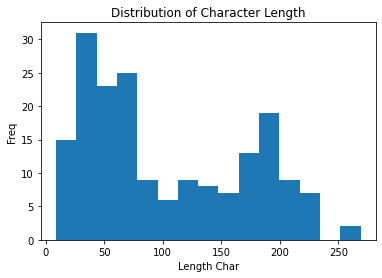

In [ ]:
length_char = df_clean['clean_tweet'].str.len()
plt.hist(length_char, bins=15)
plt.title('Distribution of Character Length')
plt.xlabel('Length Char')
plt.ylabel('Freq')

Jumlah kata pada row pada column clean_tweet

Text(0, 0.5, 'Freq')

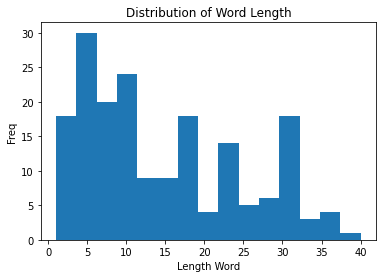

In [ ]:
#Distribusi panjang kata per tweet
length_word = df_clean['clean_tweet'].str.split().map(lambda x: len(x))
plt.hist(length_word, bins=15)
plt.title('Distribution of Word Length')
plt.xlabel('Length Word')
plt.ylabel('Freq')

Rata-rata panjang kata pada column clean_tweet

Text(0, 0.5, 'Freq')

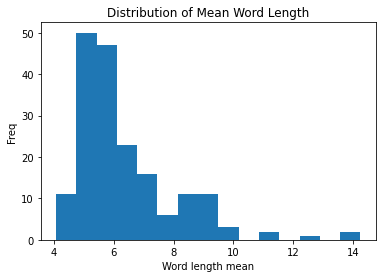

In [ ]:
word_length_mean =df_clean['clean_tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
plt.hist(word_length_mean, bins=15)
plt.title('Distribution of Mean Word Length')
plt.xlabel('Word length mean')
plt.ylabel('Freq')

Distribusi Frekuensi Kata

In [ ]:
tweet = df_clean['clean_tweet'].apply(lambda x: word_tokenize(str(x)))
tweets = [word for tweet in tweet for word in tweet]
fqdist = FreqDist(tweets)
most_common_word = fqdist.most_common(20)
most_common_word

[('tokopedia', 188),
 ('get', 37),
 ('gestun', 32),
 ('open', 27),
 ('paylater', 25),
 ('cashback', 25),
 ('up', 25),
 ('akulaku', 24),
 ('ongkir', 24),
 ('yg', 24),
 ('fee', 23),
 ('instan', 23),
 ('cek', 23),
 ('testi', 22),
 ('start', 21),
 ('min', 20),
 ('all', 18),
 ('gratis', 18),
 ('hai', 17),
 ('dp', 17)]

Visualisasi most common word pada colomn clean_tweet

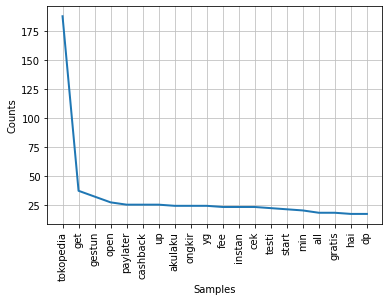

In [ ]:
fqdist.plot(20,cumulative=False)

Dari plot diatas dapat dilihat 3 kata paling sering muncul yaitu tokopedia, seller dan batal

Distribusi N-Gram 


setelah kita melihat distribusi per kata kemudian kita akan melihat distribusi n gram dengan n sebanyak 2 untuk melihat distribusi kata dengan jumlah 2 atau disebut dengan bi-gram untuk memahami isi dari clean_tweet

In [ ]:
result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
result

(open, gestun)            25
(get, cashback)           21
(fee, start)              21
(gratis, ongkir)          18
(disc, up)                16
(get, disc)               16
(talangshopee, gratis)    16
(ongkir, get)             16
(instan, akulaku)         16
(hai, sonianayxn)         16
(cashback, koin)          16
(sonianayxn, open)        16
(koin, tokopedia)         16
(reg, instan)             16
(start, reg)              16
(tokopedia, get)          16
(dp, talangshopee)        16
(akulaku, dp)             16
(up, to)                  16
(to, ktrusted)            16
dtype: int64

Dengan melihat distribusi bi-gram diatas bahwa keseluruhan tweet menggambarkan tentang aktivitas jual beli pada platfrom ecommerce seperti tokopedia dan shopee 

Text modeling

In [ ]:
data = [i.split() for i in df_clean['clean_tweet']]
data

[['tokopedia', 'ihh', 'minto', 'becanda', 'zeyeng'],
 ['ohmybeautybank',
  'dasar',
  'datacompas',
  'raine',
  'beauty',
  'top',
  'brand',
  'blush',
  'on',
  'based',
  'on',
  'market',
  'share',
  'shopee',
  'amp',
  'tokopedia',
  'official',
  'store',
  'only',
  'desember',
  'hasil',
  'ngalahin',
  'nacific',
  'amp',
  'blp',
  'congrats',
  'kak',
  'yaya',
  'raisa'],
 ['gopayindonesia', 'tokopedia', 'juta'],
 ['gopayindonesia', 'tokopedia', 'jutasemuajadiringan', 'gopaylatercicil'],
 ['rejjun', 'tokopedia', 'mall', 'gituu'],
 ['gopayindonesia',
  'tokopedia',
  'limit',
  'gopaylater',
  'cicil',
  'sd',
  'juta',
  'semuajadiringan',
  'gopaylatercicil'],
 ['plagiariqme',
  'hai',
  'sonianayxn',
  'open',
  'gestun',
  'all',
  'paylater',
  'fee',
  'start',
  'reg',
  'instan',
  'akulaku',
  'dp',
  'talangshopee',
  'gratis',
  'ongkir',
  'get',
  'cashback',
  'koin',
  'tokopedia',
  'get',
  'disc',
  'up',
  'to',
  'ktrusted',
  'fast',
  'respond',
  'j

In [ ]:
# mapping kata dalam data
dictionary = corpora.Dictionary(data)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data]

In [ ]:
#membuat model text modeling dengan topik sebanyak 3
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=3, 
    id2word = dictionary, 
    passes=50
    )
 

In [ ]:
from pprint import pprint
pprint(ldamodel.print_topics())

[(0,
  '0.049*"tokopedia" + 0.024*"get" + 0.015*"ongkir" + 0.014*"up" + 0.014*"cek" '
  '+ 0.013*"gratis" + 0.013*"fee" + 0.013*"wa" + 0.013*"hai" + 0.013*"all"'),
 (1,
  '0.062*"tokopedia" + 0.014*"min" + 0.014*"yg" + 0.009*"sukses" + '
  '0.009*"ecommerce" + 0.009*"individual" + 0.009*"kiatkiat" + '
  '0.009*"platform" + 0.009*"kemenkumham" + 0.009*"bangun"'),
 (2,
  '0.039*"tokopedia" + 0.018*"gestun" + 0.013*"kredivo" + 0.011*"amp" + '
  '0.011*"indodana" + 0.011*"open" + 0.010*"bri" + 0.010*"card" + '
  '0.010*"zonauang" + 0.010*"cashback"')]


Analisa topik dari hasil modelling :
1.   Belanja di shopee dan tokopedia dapat diskon dan free ongkir
2.   Belanja di seller tokopedia wajib buat video unboxing
3.   Gesek tunai instan di tokopedia 


# Sentiment Analysis 

Dengan menggunakan dataset pada file kata_positif dan kata_negatif kita akan menghitung jumlah dari masing-masing kata positif dan negatif pada colum clean_tweet

In [ ]:
with open("./kata_positif.txt","r") as positif_file :
  positive_words = list(set(positif_file.readlines()))
with open("./kata_negatif.txt","r") as negative_file :
  negative_words = list(set(negative_file.readlines()))


In [ ]:
hasil = []

for tweet in  df_clean['clean_tweet']:

    tweet_clean = tweet.strip().split()
    
    good_count = 0 #nilai positif
    bad_count = 0 #nilai negatif

    for good_word in positive_words:
        count = tweet_clean.count(good_word.strip().lower())
        if count > 0:
          print(good_word.strip())
          good_count += count

    for bad_word in negative_words:
        count = tweet_clean.count(bad_word.strip().lower())
        if count > 0:
          print(bad_word.strip())
          bad_count += count
    
    print ("positif: "+str(good_count))
    print ("negatif: "+str(bad_count))
    hasil.append(good_count - bad_count)
    print ("-----------------------------------------------------")

positif: 0
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
gratis
positif: 1
negatif: 0
-----------------------------------------------------
gratis
positif: 1
negatif: 0
-----------------------------------------------------
gratis
positif: 1
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
sukses
positif: 1
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
--------------------------------------

Mencari nilai descriptive statistic dari hasil 

In [ ]:
print (f'''
Mean: {np.mean(hasil)}
Median: {np.median(hasil)}
quartil awal: {np.quantile(hasil,0.25)}
quartil tengah: {np.quantile(hasil,0.5)}
quartil akhir: {np.quantile(hasil,0.75)}
Standar deviasi: {np.std(hasil)}   
Max : {max(hasil)}
Min : {min(hasil)}  
''')


Mean: 0.3224043715846995
Median: 0.0
quartil awal: 0.0
quartil tengah: 0.0
quartil akhir: 1.0
Standar deviasi: 0.9172843683612544   
Max : 4
Min : -2  



Berdasarkan data diatas dapat dilihat bahwa data terdistribusi skew right karena nilai mean lebih besar dari median (Q2) nya, selain itu nilai standard deviasi juga menunjukkan bahwa data memiliki variasi yang cukup tinggi jika dibandingkan dengan nilai mean nya terbukti dari rentan nilai min dan max nya (-2 dan 4).

kesimpulannya, data menunjukkan distribusi yang cukup ekstrem dengan nilai yang lebih tinggi dari rata-rata dan median, memiliki variasi yang cukup tinggi dan rentang data yang cukup luas. Dan mayoritas data memiliki sentimen netral karena nilai Q1 dan Q2 = 0

In [ ]:
sentiments = ["positif" if sentimen > 0 else ("netral" if sentimen == 0 else "negatif") for sentimen in hasil]
df_clean["sentiment"] = sentiments
df_clean

,tweet,descriptions,clean_tweet,sentiment
0,@tokopedia Ihh minto 😭😭😭😭 becanda zeyeng ✌,"[Brands and Companies, A taxonomy of user inte...",tokopedia ihh minto becanda zeyeng,netral
1,"@ohmybeautybank Berdasarkan #DataCompas , Rain...",[Named people in the world like Nelson Mandela...,ohmybeautybank dasar datacompas raine beauty t...,netral
2,@gopayindonesia @tokopedia 15 juta,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia juta,netral
3,@gopayindonesia @tokopedia Hingga 15 juta\n#Se...,"[Brands and Companies, A taxonomy of user inte...",gopayindonesia tokopedia jutasemuajadiringan g...,netral
4,@rejjun di tokopedia! dari mall gituu!,"[Brands and Companies, A taxonomy of user inte...",rejjun tokopedia mall gituu,netral
...,...,...,...,...
178,@dea_sehat @tokopedia @ShopeeCare @TokopediaCa...,"[Brands and Companies, Brands and Companies, B...",deasehat tokopedia shopeecare tokopediacare bu...,positif
179,@tokopedia___ @dlggity @tanyarlfes cara ngirim...,[],tokopedia dlggity tanyarlfes ngirim base giman...,netral
180,Untuk User Tokopedia silahkan cek favorit :),"[Brands and Companies, A taxonomy of user inte...",user tokopedia silah cek favorit,positif
181,@tokopedia Udah ikutan komen dari awal 😊 tingg...,"[Brands and Companies, A taxonomy of user inte...",tokopedia udah ikut komen tinggal usaha amp doa,netral


In [ ]:
counts = df_clean['sentiment'].value_counts()
percentages = (counts / len(df_clean) * 100).round(2)
result = pd.concat([counts, percentages], axis=1, keys=['counts', 'percentages'])
print(result)

         counts  percentages
netral       97        53.01
positif      65        35.52
negatif      21        11.48


Dapat dilihat untuk data kita memiliki mayoritas sentiment netral 

Visualisasi Distribusi Nilai Sentimen pada kolom clean_tweet

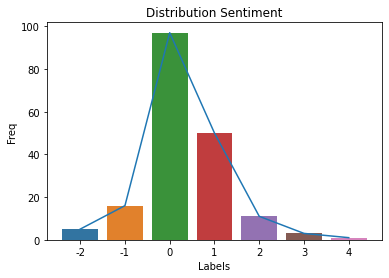

In [ ]:
labels, counts = np.unique(hasil, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(ax.get_xticks())

sns.barplot(x = list(labels), 
            y = list(counts))

sns.lineplot(x = ax.get_xticks(), 
            y = list(counts))

plt.title(f'Distribution Sentiment')
plt.xlabel('Labels')
plt.ylabel('Freq')

plt.show()

Visualisasi Distribusi Sentiment

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Freq')

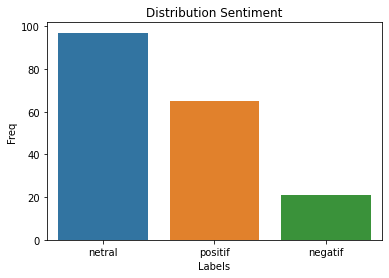

In [ ]:
sns.barplot(df_clean['sentiment'].value_counts().index,df_clean['sentiment'].value_counts())
plt.title(f'Distribution Sentiment')
plt.xlabel('Labels')
plt.ylabel('Freq')

In [ ]:
df_clean.to_csv("tokopedia_sentiment_analysis_clean.csv", index = False) 
#df_clean